<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[2025-08-03 17:50:18] Starting velocity decomposition plot generation...
[2025-08-03 17:50:18] Processing Ts = 280.0 K...
[2025-08-03 17:50:18] Processing Ts = 281.0 K...
[2025-08-03 17:50:18] Processing Ts = 282.0 K...
[2025-08-03 17:50:18] Processing Ts = 283.0 K...
[2025-08-03 17:50:19] Processing Ts = 284.0 K...
[2025-08-03 17:50:19] Processing Ts = 285.0 K...
[2025-08-03 17:50:19] Processing Ts = 286.0 K...
[2025-08-03 17:50:19] Processing Ts = 287.0 K...
[2025-08-03 17:50:19] Processing Ts = 288.0 K...
[2025-08-03 17:50:19] Processing Ts = 289.0 K...
[2025-08-03 17:50:19] Processing Ts = 290.0 K...
[2025-08-03 17:50:19] Processing Ts = 291.0 K...
[2025-08-03 17:50:19] Processing Ts = 292.0 K...
[2025-08-03 17:50:19] Processing Ts = 293.0 K...
[2025-08-03 17:50:19] Processing Ts = 294.0 K...
[2025-08-03 17:50:19] Processing Ts = 295.0 K...
[2025-08-03 17:50:19] Processing Ts = 296.0 K...
[2025-08-03 17:50:19] Processing Ts = 297.0 K...
[2025-08-03 17:50:19] Processing Ts = 298.0 K

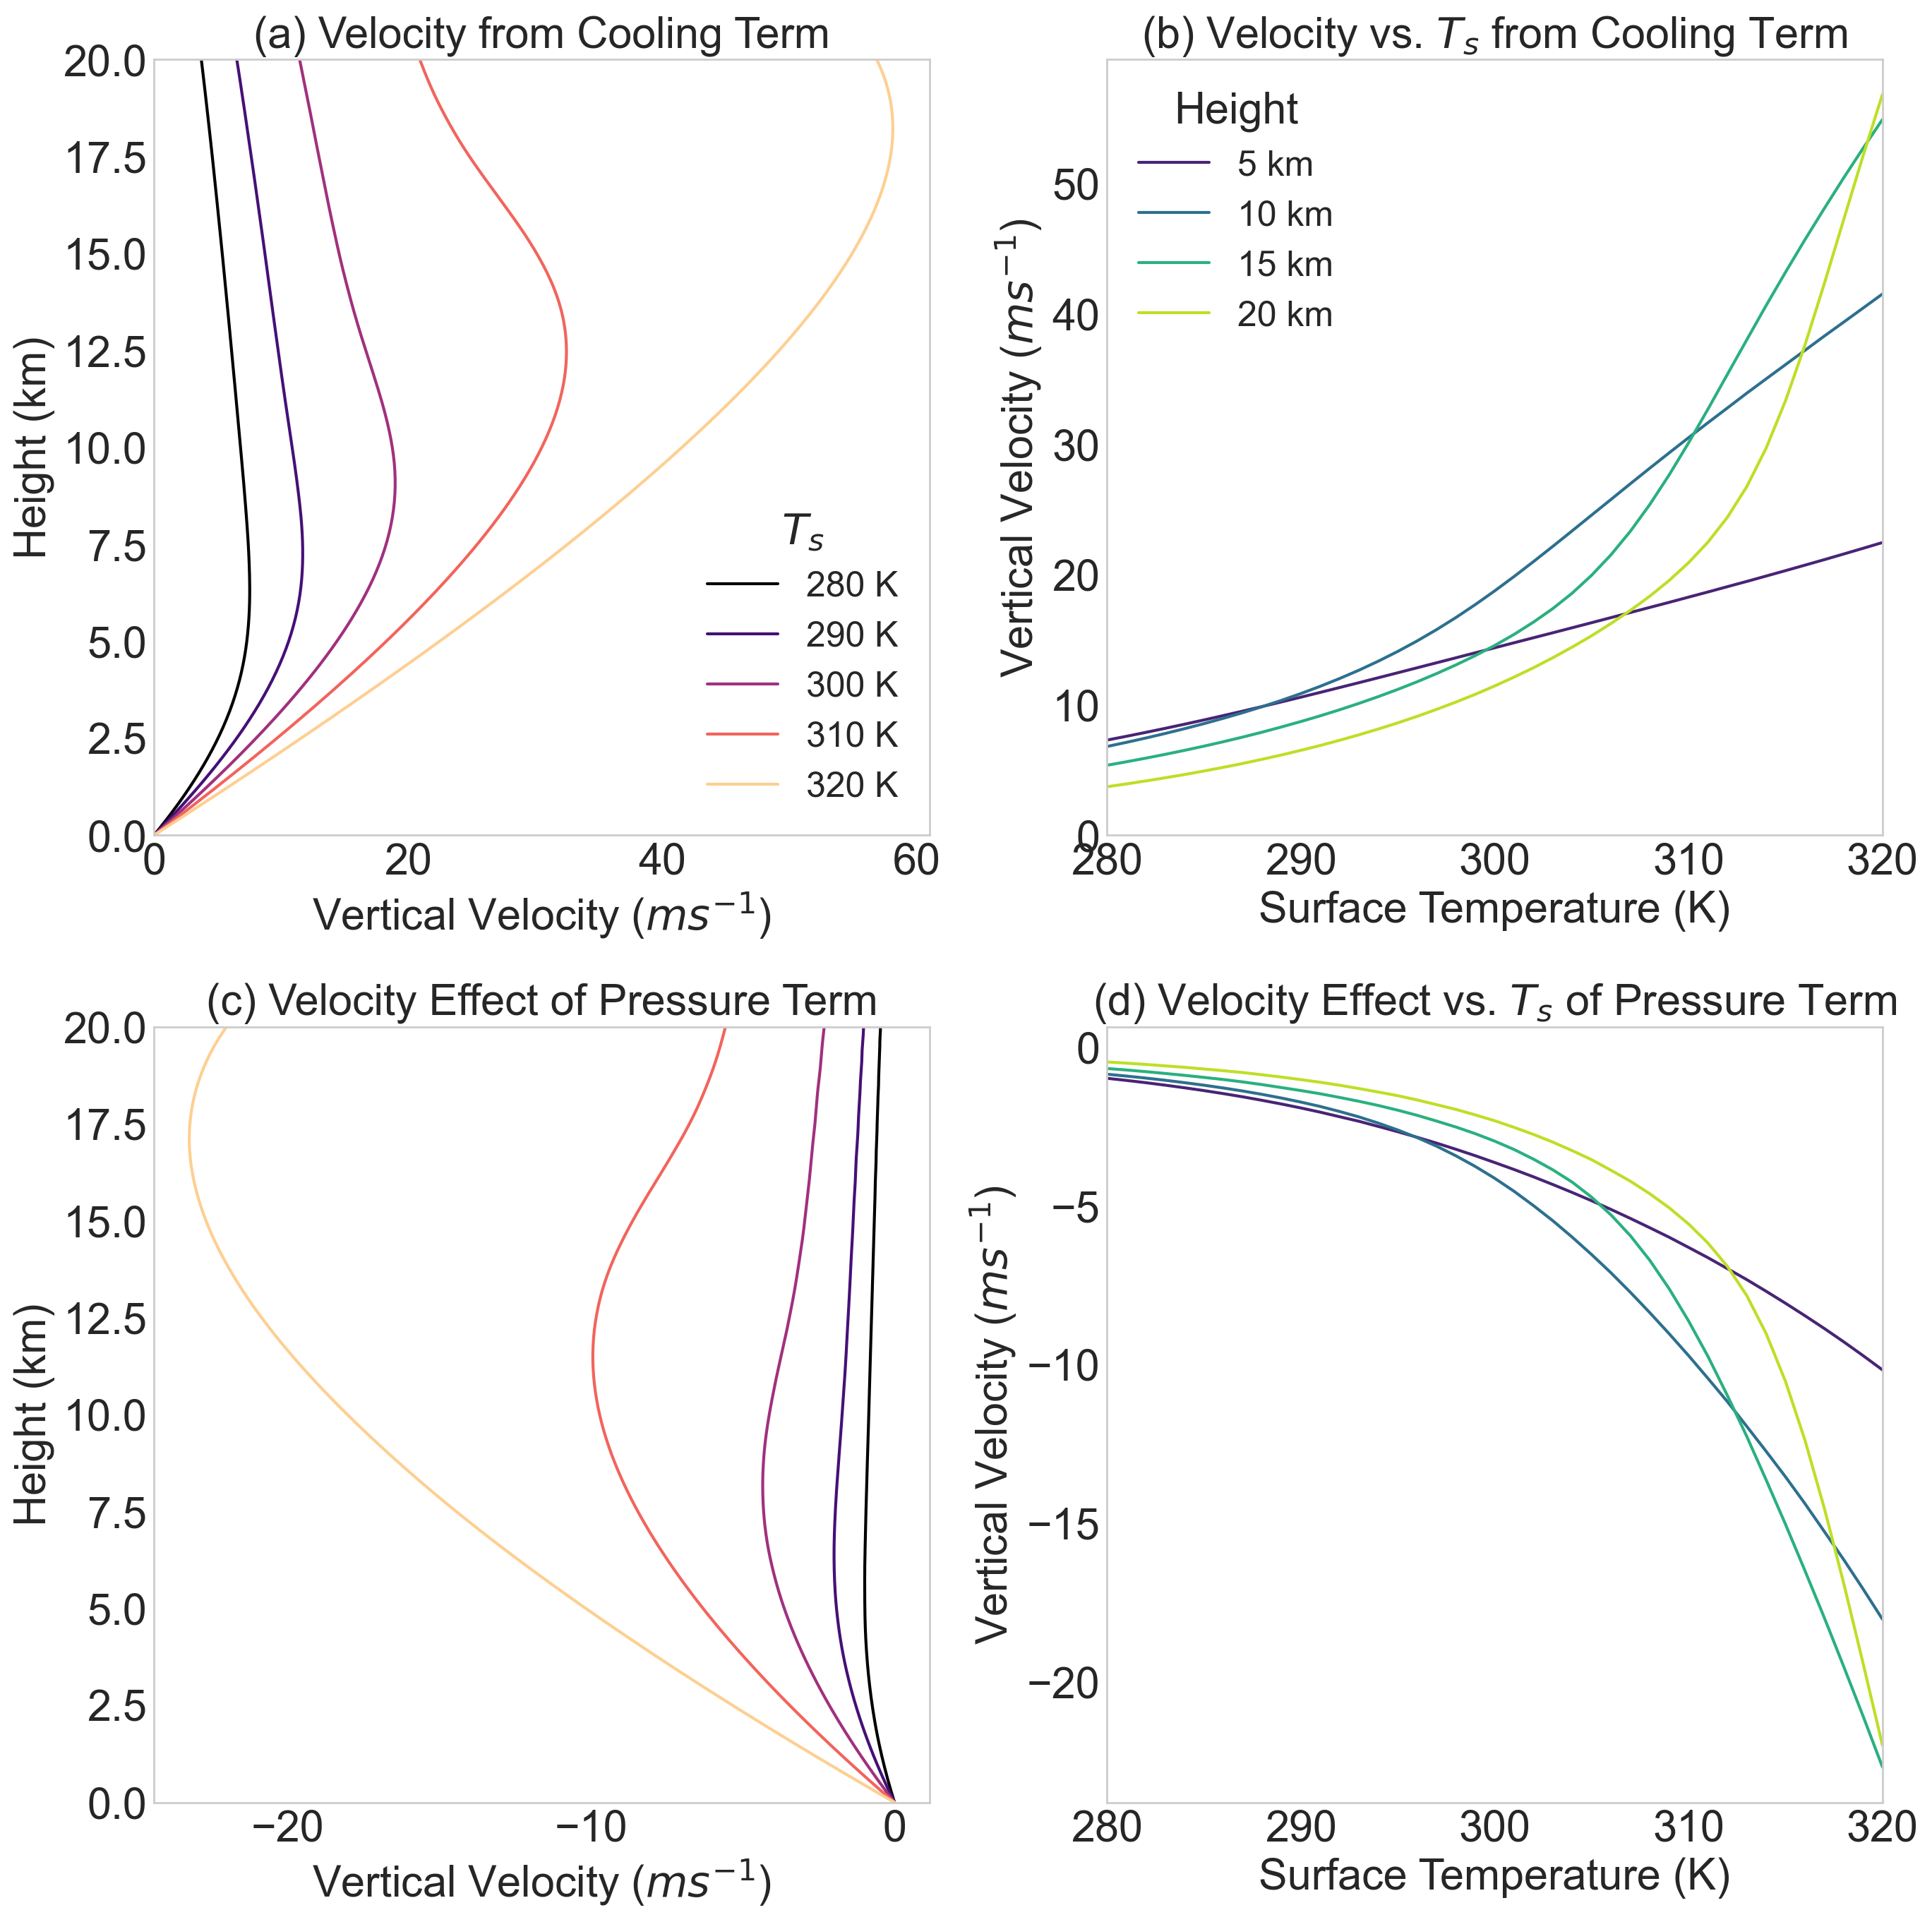

Figure 8 saved as fig-8.png


In [1]:
# ==============================================================================
# SCRIPT TO CREATE FIGURE 8:
# DECOMPOSITION OF VERTICAL VELOCITY
#
# This script decomposes the total vertical velocity profile into contributions
# driven by the "Cooling Term" and the effect of the "Pressure Term".
# The Pressure Term's contribution is calculated as the residual needed to
# recover the total velocity, representing its "braking" effect.
#
# The script performs the following actions:
# 1. Calculates the buoyancy contributions B_cool (positive) and B_pres (negative).
# 2. Solves the momentum ODE for the total velocity (w_total) using total buoyancy.
# 3. Solves the momentum ODE for the cooling-only velocity (w_cool) using B_cool.
# 4. Calculates the pressure term effect as the residual: w_total - w_cool.
# 5. Generates a 2x2 plot showing these velocity components.
# ==============================================================================

# For sharper inline plots in Jupyter environments
try:
    get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
except (NameError, AttributeError):
    pass

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.integrate import cumulative_trapezoid
import time

# --- Physical Constants and Model Parameters ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv_const = 2.501e6
A_ENTRAIN = 0.2
PE = 0.35
A_PRIME = 1.0/6.0
B_PRIME = 2.0/3.0

# --- Core Thermodynamic & Profile Functions ---
def saturation_vapor_pressure(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    denominator = np.maximum(denominator, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def dq_dT_p(p, T):
    delta_T = 0.01
    return (saturation_specific_humidity(p, T + delta_T) - saturation_specific_humidity(p, T - delta_T)) / (2 * delta_T)

def dq_dp_T(p, T):
    delta_p = 10.0
    return (saturation_specific_humidity(p + delta_p, T) - saturation_specific_humidity(p - delta_p, T)) / (2 * delta_p)

def calculate_entraining_mse(T, p, z, a):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv_const * qs / (1 + a)

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz, a):
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile, p_profile = np.full(n_steps, np.nan), np.full(n_steps, np.nan)
    T_profile[0], p_profile[0] = T_surf, p_surf
    mse_conserved = calculate_entraining_mse(T_profile[0], p_profile[0], 0.0, a)
    for i in range(n_steps - 1):
        z_c, T_c, p_c = z_profile[i], T_profile[i], p_profile[i]
        if np.isnan(T_c) or p_c <= 0: break
        z_n = z_profile[i+1]
        Tv_c = T_c * (1 + (1/epsilon - 1) * saturation_specific_humidity(p_c, T_c))
        H = (Rd * Tv_c) / g
        p_n = p_c * np.exp(-dz / H)
        if p_n <= 0: break
        try:
            sol = root_scalar(lambda T_g: calculate_entraining_mse(T_g, p_n, z_n, a) - mse_conserved, bracket=[50.0, T_c + 5], method='brentq')
            if sol.converged: T_profile[i+1], p_profile[i+1] = sol.root, p_n
            else: break
        except (ValueError, RuntimeError): break
    valid = ~np.isnan(T_profile)
    return z_profile[valid], T_profile[valid], p_profile[valid]

def main():
    """Main function to execute the calculation and plotting."""
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting velocity decomposition plot generation...")

    # --- Parameters ---
    P_SURFACE_PA = 100000.0
    Z_MAX_M = 25000
    T_surf_range_K = np.arange(280, 320.1, 1.0)
    z_grid_m = np.arange(0, Z_MAX_M, 100)
    z_grid_km = z_grid_m / 1000.0

    velocity_from_cooling_grid = np.full((len(z_grid_m), len(T_surf_range_K)), np.nan)
    velocity_from_pressure_grid = np.full((len(z_grid_m), len(T_surf_range_K)), np.nan)

    # --- Calculation Loop ---
    for i, t_surf in enumerate(T_surf_range_K):
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Processing Ts = {t_surf:.1f} K...")

        # 1. Calculate profiles and buoyancy components
        z_env, t_env, p_env = calculate_moist_adiabatic_profile(t_surf, P_SURFACE_PA, Z_MAX_M, 100, a=A_ENTRAIN)
        if len(z_env) < 2: continue

        interp_t_env = interp1d(z_env, t_env, bounds_error=False, fill_value=np.nan)
        interp_p_env = interp1d(z_env, p_env, bounds_error=False, fill_value=np.nan)
        t_env_grid = interp_t_env(z_grid_m)
        p_env_grid = interp_p_env(z_grid_m)

        gamma_m_grid = -np.gradient(t_env_grid, 100)
        rho_grid = p_env_grid / (Rd * t_env_grid)

        cooling_comp_dqs = -gamma_m_grid * dq_dT_p(p_env_grid, t_env_grid)
        pressure_comp_dqs = -rho_grid * g * dq_dp_T(p_env_grid, t_env_grid)

        prefactor_const = (A_ENTRAIN / (1 + A_ENTRAIN)) * (Lv_const / cpd)
        buoyancy_from_cooling = -(g / t_env_grid) * prefactor_const * cumulative_trapezoid(cooling_comp_dqs, z_grid_m, initial=0)
        buoyancy_from_pressure = -(g / t_env_grid) * prefactor_const * cumulative_trapezoid(pressure_comp_dqs, z_grid_m, initial=0)
        buoyancy_total = buoyancy_from_cooling + buoyancy_from_pressure

        buoyancy_cool_func = interp1d(z_grid_m, np.nan_to_num(buoyancy_from_cooling), bounds_error=False, fill_value=0)
        buoyancy_total_func = interp1d(z_grid_m, np.nan_to_num(buoyancy_total), bounds_error=False, fill_value=0)

        qs_env = saturation_specific_humidity(p_env_grid, t_env_grid)
        gamma = -np.gradient(np.log(qs_env), z_grid_m)
        entrainment_rate_on_grid = (A_ENTRAIN * gamma) / PE
        entrainment_func = interp1d(z_grid_m, np.nan_to_num(entrainment_rate_on_grid), bounds_error=False, fill_value=0)

        # 2. Define and solve ODE
        def momentum_ode(z, y, B_func):
            w_sq = y[0]
            B = B_func(z)
            E = entrainment_func(z)
            drag_term = (A_PRIME + B_PRIME) * E * w_sq
            dw_sq_dz = 2 * (A_PRIME * B - drag_term)
            return [dw_sq_dz]

        # Solve for total velocity
        sol_total = solve_ivp(momentum_ode, [0, Z_MAX_M], [0], dense_output=True, args=(buoyancy_total_func,), method='RK45')
        w_sq_total = sol_total.sol(z_grid_m)[0]
        w_total = np.sqrt(np.maximum(0, w_sq_total))

        # Solve for cooling-only velocity
        sol_cool = solve_ivp(momentum_ode, [0, Z_MAX_M], [0], dense_output=True, args=(buoyancy_cool_func,), method='RK45')
        w_sq_cool = sol_cool.sol(z_grid_m)[0]
        w_cool = np.sqrt(np.maximum(0, w_sq_cool))

        velocity_from_cooling_grid[:, i] = w_cool
        velocity_from_pressure_grid[:, i] = w_total - w_cool

    # --- Visualization ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Calculation complete. Generating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    base_fontsize = 22

    T_plot_values = np.arange(280, 320.1, 10.0)
    cmap_profiles = plt.get_cmap('magma')
    colors_profiles = cmap_profiles(np.linspace(0, 0.9, len(T_plot_values)))

    z_levels_km = [5, 10, 15, 20]
    cmap_altitudes = plt.get_cmap('viridis')
    colors_altitudes = cmap_altitudes(np.linspace(0.1, 0.9, len(z_levels_km)))

    # --- Row 1: Cooling Term ---
    ax_cool_prof, ax_cool_alt = axes[0, 0], axes[0, 1]
    ax_cool_prof.set_title('(a) Velocity from Cooling Term', fontsize=base_fontsize)
    ax_cool_alt.set_title('(b) Velocity vs. $T_{s}$ from Cooling Term', fontsize=base_fontsize)
    for i, t_val in enumerate(T_plot_values):
        t_idx = np.argmin(np.abs(T_surf_range_K - t_val))
        ax_cool_prof.plot(velocity_from_cooling_grid[:, t_idx], z_grid_km, label=f'{int(t_val)} K', color=colors_profiles[i])
    for i, z_km in enumerate(z_levels_km):
        z_idx = np.argmin(np.abs(z_grid_km - z_km))
        ax_cool_alt.plot(T_surf_range_K, velocity_from_cooling_grid[z_idx, :], label=f'{z_km} km', color=colors_altitudes[i])

    # --- Row 2: Pressure Term ---
    ax_pres_prof, ax_pres_alt = axes[1, 0], axes[1, 1]
    ax_pres_prof.set_title('(c) Velocity Effect of Pressure Term', fontsize=base_fontsize)
    ax_pres_alt.set_title('(d) Velocity Effect vs. $T_{s}$ of Pressure Term', fontsize=base_fontsize)
    for i, t_val in enumerate(T_plot_values):
        t_idx = np.argmin(np.abs(T_surf_range_K - t_val))
        ax_pres_prof.plot(velocity_from_pressure_grid[:, t_idx], z_grid_km, label=f'{int(t_val)} K', color=colors_profiles[i])
    for i, z_km in enumerate(z_levels_km):
        z_idx = np.argmin(np.abs(z_grid_km - z_km))
        ax_pres_alt.plot(T_surf_range_K, velocity_from_pressure_grid[z_idx, :], label=f'{z_km} km', color=colors_altitudes[i])

    # --- Formatting and Labels ---
    ax_cool_prof.legend(title='$T_{s}$', title_fontsize=base_fontsize, fontsize=base_fontsize - 4)
    ax_cool_alt.legend(title='Height', title_fontsize=base_fontsize, fontsize=base_fontsize - 4)

    # Set labels for all axes
    axes[0,0].set_ylabel('Height (km)', fontsize=base_fontsize)
    axes[1,0].set_ylabel('Height (km)', fontsize=base_fontsize)
    axes[0,1].set_ylabel('Vertical Velocity ($m s^{-1}$)', fontsize=base_fontsize)
    axes[1,1].set_ylabel('Vertical Velocity ($m s^{-1}$)', fontsize=base_fontsize)

    axes[0,0].set_xlabel('Vertical Velocity ($m s^{-1}$)', fontsize=base_fontsize)
    axes[1,0].set_xlabel('Vertical Velocity ($m s^{-1}$)', fontsize=base_fontsize)
    axes[0,1].set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)
    axes[1,1].set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)

    # Apply settings to all axes
    for ax in axes.flatten():
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
        ax.grid(False)
        ax.set_box_aspect(1)
        # We can remove the redundant legends from the bottom row for a cleaner look
        if ax in [axes[1,0], axes[1,1]]:
            if ax.get_legend() is not None:
                ax.get_legend().remove()

    # Set axis limits
    axes[0,0].set_ylim(0, 20)
    axes[1,0].set_ylim(0, 20)
    axes[0,1].set_xlim(280, 320)
    axes[1,1].set_xlim(280, 320)
    ax_cool_prof.set_xlim(left=0)
    ax_cool_alt.set_ylim(bottom=0)

    plt.tight_layout(pad=2.0)
    fig8_filename = "fig-8.png"
    plt.savefig(fig8_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure 8 saved as {fig8_filename}")


if __name__ == '__main__':
    main()
